In [71]:
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Read the input data

In [72]:
df = pd.read_csv("LOG_SOLUBILITY_results.csv")

Extract the test sets with butina splits

In [106]:
df_test = df.query("dset == 'test' and group == 'butina'")

Create a list of model types

In [107]:
model_list = ["chemprop","lgbm_morgan","lgbm_prop"]

Collect $R^2$ and RMSE stats

In [108]:
stat_list = []
for k,v in df_test.groupby("fold"):
    for model in model_list:
        stat_list.append([k,model,r2_score(v.LOG_SOLUBILITY, v[model]),root_mean_squared_error(v.LOG_SOLUBILITY, v[model])])
stat_df = pd.DataFrame(stat_list,columns=["fold","model","r2","rmse"])

Make boxplots of $R^2$ and RMSE. This just provides a quick view of the results and doesn't present any statistical comparisons.

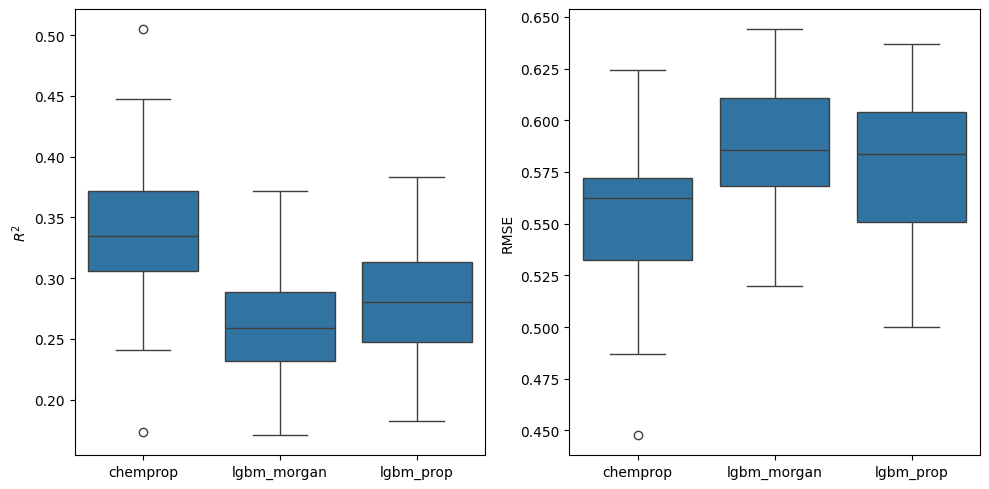

In [109]:
figure, axes = plt.subplots(1,2,figsize=(10,5))
ax0 = sns.boxplot(x="model",y="r2",data=stat_df,ax=axes[0])
ax0.set_xlabel("")
ax0.set_ylabel("$R^2$")
ax1 = sns.boxplot(x="model",y="rmse",data=stat_df,ax=axes[1])
ax1.set_ylabel("RMSE")
ax1.set_xlabel("")
plt.tight_layout()

Create a list of model paris for the paired plots.  The paired plots provide a view into individual cross-validation folds. 

In [110]:
model_pair_list = list(combinations(model_list,2))
model_pair_list

[('chemprop', 'lgbm_morgan'),
 ('chemprop', 'lgbm_prop'),
 ('lgbm_morgan', 'lgbm_prop')]

Make the paired plots for $R^2$

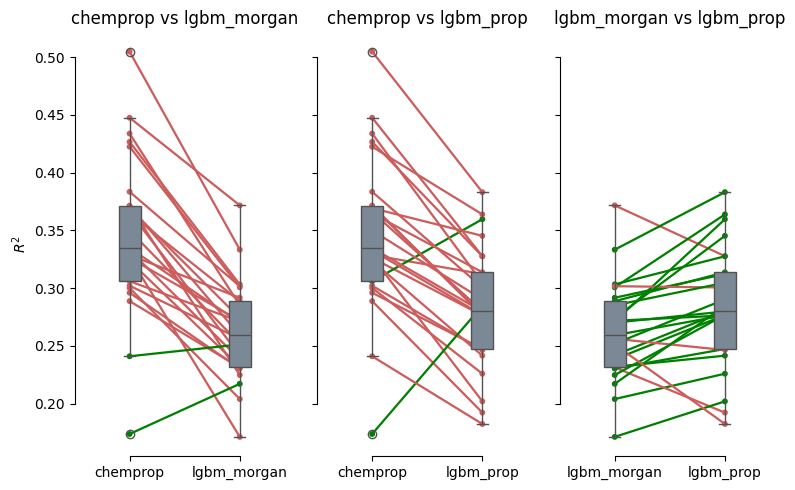

In [119]:
figure, axes = plt.subplots(1,len(model_pair_list),figsize=(8,5),sharey=True)
for idx,p in enumerate(model_pair_list):
    tmp_df = stat_df.query("model in @p")
    ax = pg.plot_paired(tmp_df,dv="r2",within="model",subject="fold",ax=axes[idx])
    ax.set_ylabel("$R^2$")
    ax.set_xlabel("")
    ax.set_title(" vs ".join(p))
plt.tight_layout()

Calculate [Tukey's Honestly Significant Difference (HSD)](https://en.wikipedia.org/wiki/Tukey%27s_range_test) for $R^2$.  This allows us to determine whether we can reject the null hypothesis that the means of the distributions are the same. 

In [112]:
tukey_res = pairwise_tukeyhsd(endog=stat_df.r2,groups=stat_df.model)
print(tukey_res)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
   chemprop lgbm_morgan  -0.0848    0.0 -0.1224 -0.0471   True
   chemprop   lgbm_prop   -0.063 0.0004 -0.1006 -0.0253   True
lgbm_morgan   lgbm_prop   0.0218 0.3532 -0.0158  0.0594  False
--------------------------------------------------------------


Plot confidence intervals for Tukey's HSD.  In this case, we use ChemProp as the reference.  Any pair where we can reject the null hypothesis will be shown in red. 

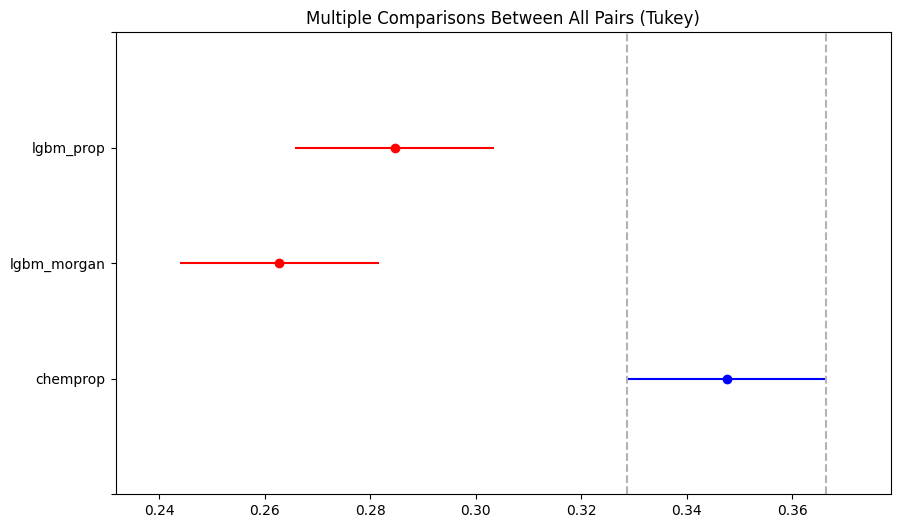

In [113]:
_ = tukey_res.plot_simultaneous(comparison_name="chemprop")

Make the paired plots for RMSE

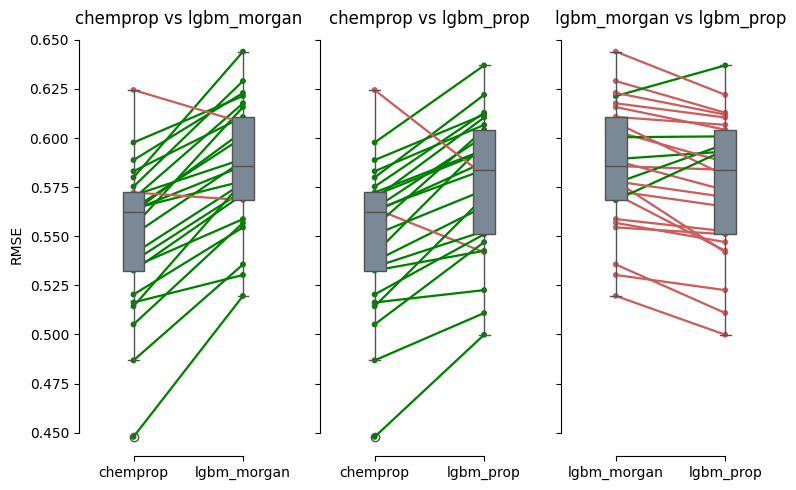

In [120]:
figure, axes = plt.subplots(1,len(model_pair_list),figsize=(8,5),sharey=True)
for idx,p in enumerate(model_pair_list):
    tmp_df = stat_df.query("model in @p")
    ax = pg.plot_paired(tmp_df,dv="rmse",within="model",subject="fold",ax=axes[idx])
    ax.set_title(" vs ".join(p))
    ax.set_ylabel("RMSE")
    ax.set_xlabel("")
plt.tight_layout()

Calculate Tukey's Honestly Significant Difference (HSD) for RMSE

In [123]:
tukey_res = pairwise_tukeyhsd(endog=stat_df.rmse,groups=stat_df.model)
print(tukey_res)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   chemprop lgbm_morgan   0.0352 0.0021  0.0113 0.0592   True
   chemprop   lgbm_prop   0.0265 0.0266  0.0025 0.0504   True
lgbm_morgan   lgbm_prop  -0.0088 0.6579 -0.0327 0.0152  False
-------------------------------------------------------------


Plot confidence intervals for Tukey's HSD.  In this case, we use ChemProp as the reference.  Any pair where we can reject the null hypothesis will be shown in red. 

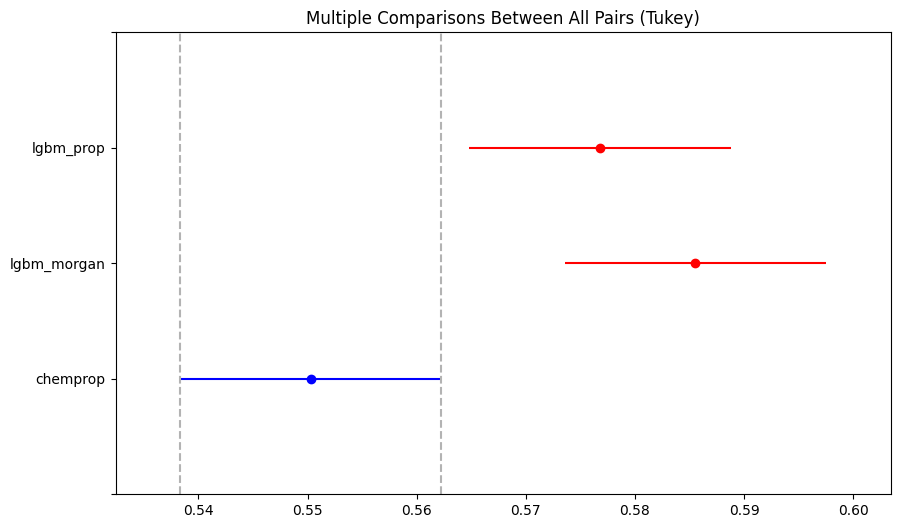

In [125]:
_ = tukey_res.plot_simultaneous(comparison_name="chemprop")